## table of contents
1. [overall](#overall)
2. [model](#model)
3. [explainable ai](#explainable_ai)
4. [test](#test)
5. [profitability](#profitability)

___
## overall

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import shap
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

import mlframework

In [2]:
data = pd.read_parquet('/Users/khanhtpd/Projects/aai_banca_ls_v3/model/banca_hub_202203/banca_202101/part-00000-7624f56d-d0fc-4f83-abe5-47b984dc8b54-c000.snappy.parquet')
data['AGE'] = data['AGE'].astype(float)
data = data.sample(10000)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 69255 to 110234
Columns: 502 entries, REF_TIME to LENDING_SUM_BAL_3M
dtypes: float64(496), int32(3), object(3)
memory usage: 38.3+ MB


REF_TIME     CUSID  LABEL_TIME  LABEL  GENDER         CITY   AGE  \
69255   20210731  28612208      202109      0  FEMALE    BINH-DINH  34.0   
115018  20200930  34123663      202011      0    MALE      LONG-AN  34.0   
8063    20210731  21266184      202109      0    MALE  HO-CHI-MINH  36.0   
71933   20210731  20251692      202109      0  FEMALE    HAI-PHONG  38.0   
94752   20210630  35417986      202108      0    MALE    THANH-HOA  34.0   

        MONTH_ON_BANK  CASA_BAL_MEAN_BAL_INCREASE_GREATER_1E6_6M  \
69255            91.0                                   0.005650   
115018           17.0                                   0.220994   
8063            162.0                                   0.112994   
71933           185.0                                   0.033898   
94752            17.0                                   0.057143   

        CASA_BAL_MEAN_BAL_INCREASE_GREATER_30E6_6M  ...  LENDING_MAX_BAL_6M  \
69255                                     0.005650  ...                 NaN   
115018                                    0.033149  ...          21346000.0   
8063                                      0.005650  ...                 NaN   
71933                                     0.016949  ...                 NaN   
94752                                     0.017143  ...                 NaN   

        LENDING_VARIANCE_BAL_6M  LENDING_MEAN_BAL_6M  LENDING_VARIANCE_BAL_3M  \
69255                       NaN                  NaN                      NaN   
115018             6.652593e+13           10066337.6             7.640890e+13   
8063                        NaN                  NaN                      NaN   
71933                       NaN                  NaN                      NaN   
94752                       NaN                  NaN                      NaN   

        LENDING_MAX_BAL_3M  LENDING_MIN_BAL_6M  LENDING_SUM_BAL_6M  \
69255                  NaN                 NaN                 NaN   
115018          21346000.0           1072500.0          50331688.0   
8063                   NaN                 NaN                 NaN   
71933                  NaN                 NaN                 NaN   
94752                  NaN                 NaN                 NaN   

        LENDING_MIN_BAL_3M  LENDING_MEAN_BAL_3M  LENDING_SUM_BAL_3M  
69255                  NaN                  NaN                 NaN  
115018           5376700.0         1.130755e+07          33922655.0  
8063                   NaN                  NaN                 NaN  
71933                  NaN                  NaN                 NaN  
94752                  NaN                  NaN                 NaN  

[5 rows x 502 columns]

Data is resulted from feature engineering, having 10,000 rows and 502 columns

___
## model

In [3]:
label_col = 'LABEL'
feat_cols = [col for col in data.columns if col not in ['REF_TIME', 'CUSID', 'LABEL_TIME', 'LABEL']]

In [4]:
# Split data and tune lightgbm with optuna
ml = mlframework.MLFramework(data)
ml.train_valid_test_split(
    label_col=label_col,
    time_col='REF_TIME',
    feat_cols=feat_cols,
    valid_size=0,  # not split for valid set yet. will be split in cross validation process
    test_size=2  # keep 20% of the data for testing
)

test is out-of-time sampled.
New attributes: data, train_label, train_feat, valid_label, valid_feat, test_label, test_feat.


In [5]:
ml.test_feat

GENDER         CITY   AGE  MONTH_ON_BANK  \
78732      NaN          NaN  22.0            5.0   
139488  FEMALE       HA-NOI  35.0           75.0   
16391      NaN          NaN   NaN            NaN   
52246   FEMALE       HA-NOI  38.0          110.0   
11205   FEMALE       HA-NOI  34.0          148.0   
...        ...          ...   ...            ...   
131348    MALE     LANG-SON  24.0           37.0   
173855    MALE  HO-CHI-MINH  38.0           47.0   
73155      NaN          NaN   NaN            NaN   
143947  FEMALE       HA-NOI  30.0           79.0   
110234  FEMALE  HO-CHI-MINH  32.0           41.0   

        CASA_BAL_MEAN_BAL_INCREASE_GREATER_1E6_6M  \
78732                                    0.000000   
139488                                        NaN   
16391                                         NaN   
52246                                    0.005464   
11205                                    0.278689   
...                                           ...   
131348                                   0.087432   
173855                                   0.000000   
73155                                         NaN   
143947                                   0.136612   
110234                                   0.120219   

        CASA_BAL_MEAN_BAL_INCREASE_GREATER_30E6_6M  \
78732                                     0.000000   
139488                                         NaN   
16391                                          NaN   
52246                                     0.000000   
11205                                     0.010929   
...                                            ...   
131348                                    0.000000   
173855                                    0.000000   
73155                                          NaN   
143947                                    0.005464   
110234                                    0.005464   

        CASA_BAL_VARIANCE_BAL_CHANGE_6M  \
78732                      0.000000e+00   
139488                              NaN   
16391                               NaN   
52246                      8.049053e+09   
11205                      4.187705e+15   
...                                 ...   
131348                     1.654136e+12   
173855                     0.000000e+00   
73155                               NaN   
143947                     3.054006e+13   
110234                     4.361692e+13   

        CASA_BAL_MEAN_BAL_DECREASE_LOWER_1E6_6M  \
78732                                  0.000000   
139488                                      NaN   
16391                                       NaN   
52246                                  0.000000   
11205                                  0.131148   
...                                         ...   
131348                                 0.098361   
173855                                 0.000000   
73155                                       NaN   
143947                                 0.147541   
110234                                 0.207650   

        CASA_BAL_MEAN_BAL_INCREASE_GREATER_5E6_6M  CASA_BAL_MAX_BAL_CHANGE_6M  \
78732                                    0.000000                         0.0   
139488                                        NaN                         NaN   
16391                                         NaN                         NaN   
52246                                    0.000000                   1083000.0   
11205                                    0.158470                 502652377.0   
...                                           ...                         ...   
131348                                   0.010929                   6392614.0   
173855                                   0.000000                         0.0   
73155                                         NaN                         NaN   
143947                                   0.071038                  34322389.0   
110234                                   0.087432                  34000000.

In [6]:
ml.tune(5)

[I 2022-03-07 21:40:08,668] A new study created in memory with name: no-name-3684100e-65c7-420e-9d4d-ecf85ef08756
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


---------> Fixed params:
'objective': binary
'metric': auc
'learning_rate': 0.1
'verbose': -1
---------> Tuning params:
'num_leaves': IntUniformDistribution(high=1023, low=15, step=1)
'max_depth': IntUniformDistribution(high=12, low=3, step=1)
'min_data_in_leaf': IntUniformDistribution(high=100, low=10, step=1)
'subsample': UniformDistribution(high=1.0, low=0.3)
'colsample_bytree': UniformDistribution(high=1.0, low=0.3)
'reg_alpha': LogUniformDistribution(high=10.0, low=1e-08)
'reg_lambda': LogUniformDistribution(high=10.0, low=1e-08)



'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
[I 2022-03-07 21:40:17,567] Trial 0 finished with value: 0.5739958790720807 and parameters: {'num_leaves': 568, 'max_depth': 10, 'min_data_in_leaf': 64, 'subsample': 0.6814182280978278, 'colsample_bytree': 0.5965583595372332, 'reg_alpha': 0.006502000785097662, 'reg_lambda': 8.675307976899775e-05}. Best is trial 0 with value: 0.5739958790720807.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


KeyboardInterrupt: 

In [7]:
feat_importance = ml.get_feature_importance(len(ml.data.columns))
(feat_importance > 0).value_counts()

True     372
False    126
Name: importance, dtype: int64

Only a part out of 191 features are used during the split (feature importance > 0). Since just a sub set of columns are selected at every split, these unuseful features may harm the performance of the split. Should remove them and re-train the model.

In [8]:
feat_cols = feat_importance.loc[lambda x: x > 0].index
ml.train_valid_test_split(
    label_col=label_col,
    feat_cols=feat_cols,
    valid_size=0,  # not split for valid set yet. will be split in cross validation process
    test_size=0.2  # keep 20% of the data for testing
)
ml.tune(5)

[I 2022-03-06 09:57:35,910] A new study created in memory with name: no-name-dcb35e66-af6a-4e45-9474-871138a687d8


test is randomly sampled.
New attributes: data, train_label, train_feat, valid_label, valid_feat, test_label, test_feat.
---------> Fixed params:
'objective': binary
'metric': auc
'learning_rate': 0.1
'verbose': -1
---------> Tuning params:
'num_leaves': IntUniformDistribution(high=1023, low=15, step=1)
'max_depth': IntUniformDistribution(high=12, low=3, step=1)
'min_data_in_leaf': IntUniformDistribution(high=100, low=10, step=1)
'subsample': UniformDistribution(high=1.0, low=0.3)
'colsample_bytree': UniformDistribution(high=1.0, low=0.3)
'reg_alpha': LogUniformDistribution(high=10.0, low=1e-08)
'reg_lambda': LogUniformDistribution(high=10.0, low=1e-08)



[I 2022-03-06 09:57:39,388] Trial 0 finished with value: 0.6440046340761555 and parameters: {'num_leaves': 568, 'max_depth': 10, 'min_data_in_leaf': 64, 'subsample': 0.6814182280978278, 'colsample_bytree': 0.5965583595372332, 'reg_alpha': 0.006502000785097662, 'reg_lambda': 8.675307976899775e-05}. Best is trial 0 with value: 0.6440046340761555.
[I 2022-03-06 09:57:57,771] Trial 1 finished with value: 0.6452694730615554 and parameters: {'num_leaves': 914, 'max_depth': 12, 'min_data_in_leaf': 44, 'subsample': 0.8542075266578653, 'colsample_bytree': 0.6702264438270331, 'reg_alpha': 0.001295391520396607, 'reg_lambda': 2.13978305808933}. Best is trial 1 with value: 0.6452694730615554.
[I 2022-03-06 09:57:59,358] Trial 2 finished with value: 0.6264913131559322 and parameters: {'num_leaves': 86, 'max_depth': 3, 'min_data_in_leaf': 11, 'subsample': 0.8828338918835565, 'colsample_bytree': 0.8447097256648952, 'reg_alpha': 0.6762532016190338, 'reg_lambda': 6.42044426233932}. Best is trial 1 with 

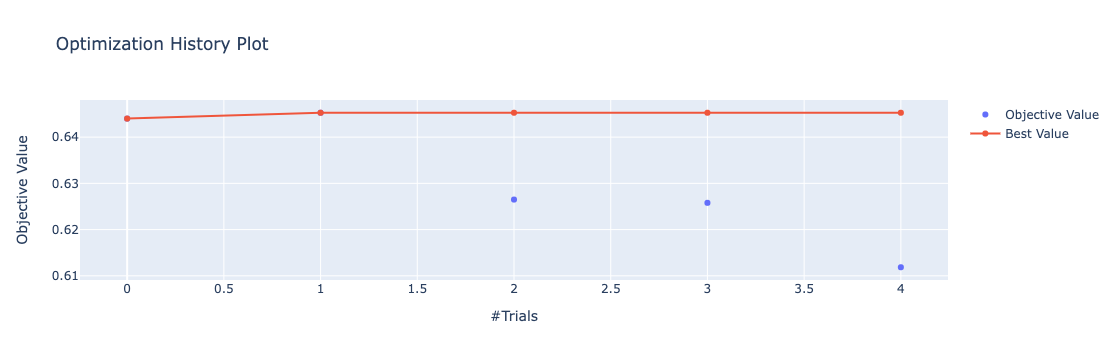

In [10]:
plot_optimization_history(ml.study)

The metric generally increases through out the trials. The best trial is 41st.

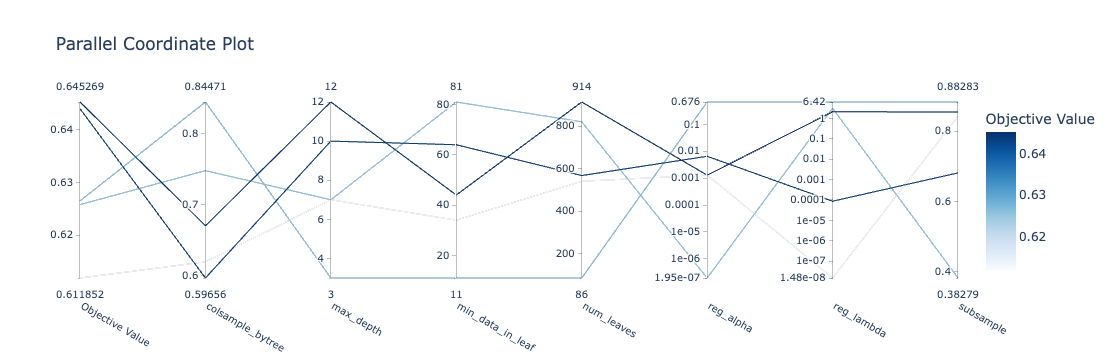

In [11]:
plot_parallel_coordinate(ml.study)

The chart may help provide ideas to tune more at some specific hyperparameters such as `max_depth` or `min_data_in_leaf`.

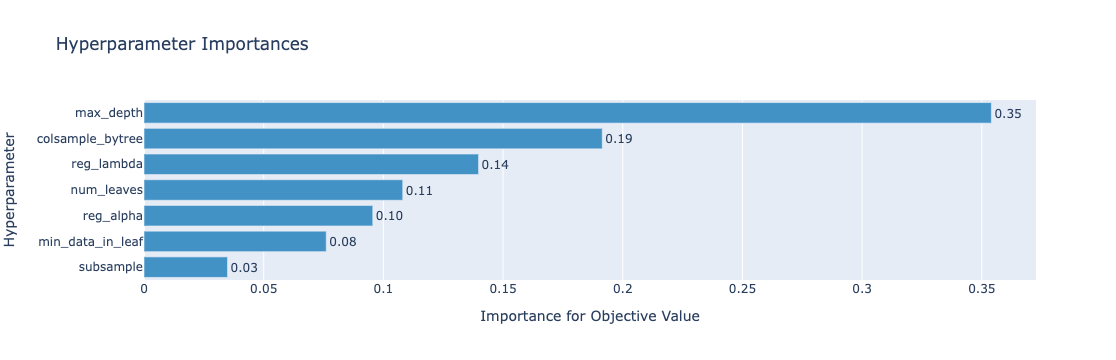

In [12]:
plot_param_importances(ml.study)

As expected, the most hyperparameters of this model are `max_depth`, `min_data_in_leaf` and `num_leaves`. Actually, if the time is surplus, it can be even better to tune explicitly these top hypterparamters to reach better metric.

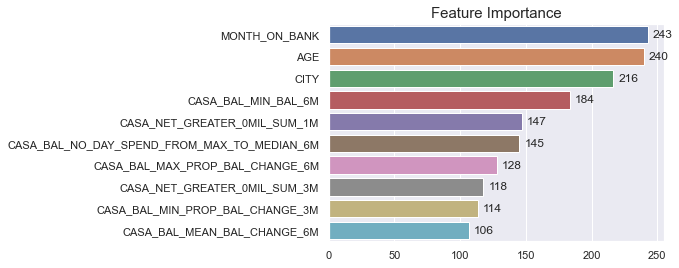

In [13]:
ml.plot_feature_importance()

Many of the top important feature are installed apps: `pd_app_com.shopee.id`, `ph_app_com.tangbull.phonerepayment` and `pd_app_com.kreditpintar`. Those contribute to best splits.

___
## explainable_ai

In [14]:
explainer = shap.TreeExplainer(ml.booster)
shap_values = explainer.shap_values(ml.train_feat)

/opt/anaconda3/lib/python3.8/site-packages/shap/explainers/_tree.py:351: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



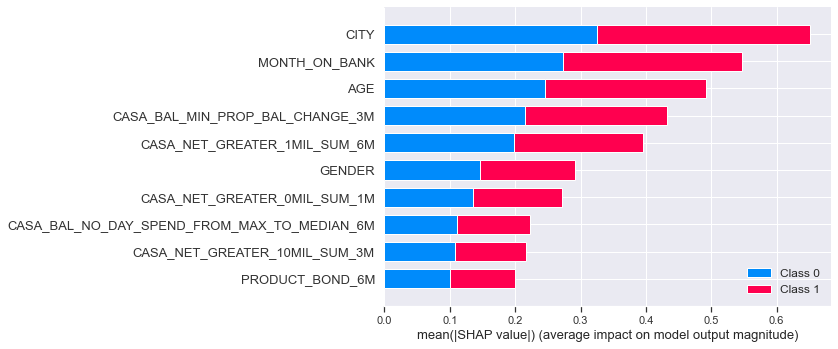

In [15]:
shap.summary_plot(shap_values, ml.train_feat, max_display=10)

Though the shapley value chart is not exactly the same as feature importance based on the tree splits (in previous chart), the top important ones stil remain.

In [16]:
sample_index = 10

shap.initjs()
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][sample_index,:],
    ml.train_feat.iloc[sample_index,:]
)

`shap` package can break down the prediction of a sample into contributions of every features. For example, the session index 10 has prediction of -2.19 (note that this is the log odds of the probability, inverse the function to get the probability). The contribution is intepreted as following:

1. `pd_app_com.shopee.id = 1` decreases significantly the chance it comes from a bad user.
2. `pd_call_total_calls = 28` decreases fairly the chance it comes from a bad user.
3. `de_employment_duration = 24` increases the chance it comes from a bad user.
4. ...

In [17]:
sample_index_from = 0
sample_index_to = 100

shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][sample_index_from: sample_index_to, :], 
    ml.train_feat.iloc[sample_index_from: sample_index_to,:]
)

Aggreate chart of contributions for many samples.

___
## test

In [19]:
true = ml.test_label
pred = ml.predict(ml.test_feat)

In [22]:
auc = mlframework.get_auc(true, pred)
print(f'AUC on test set is: {auc:.2%}')

AUC on test set is: 59.62%


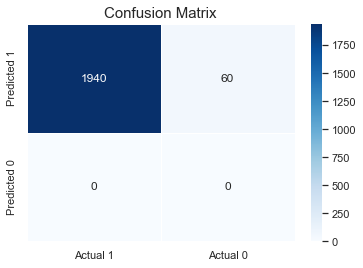

In [20]:
mlframework.get_confusion_matrix(true, pred)

Assume the cut-off is 0.5, most of the users are predict as good (as expected). From the confusion matrix, recall can be calculated as 0.157, precision can be calculate as 0.649. The cut-off needs to be considered carefully based on the context. Following part will justify the optimal cut-off.

In [23]:
mlframework.get_gain_table(true, pred)

level  predict_min  predict_mean  predict_max  true_count  true_sum  \
0   Level1     0.009040      0.046074     0.232992         200        14   
1   Level2     0.001966      0.003952     0.008981         200         7   
2   Level3     0.000982      0.001420     0.001965         200         4   
3   Level4     0.000599      0.000772     0.000979         200         8   
4   Level5     0.000365      0.000468     0.000598         200         4   
5   Level6     0.000233      0.000290     0.000365         200         5   
6   Level7     0.000151      0.000189     0.000233         200         7   
7   Level8     0.000094      0.000120     0.000150         200         3   
8   Level9     0.000046      0.000070     0.000094         200         4   
9  Level10     0.000005      0.000029     0.000046         200         4   

   true_mean  
0      0.070  
1      0.035  
2      0.020  
3      0.040  
4      0.020  
5      0.025  
6      0.035  
7      0.015  
8      0.020  
9      0.020

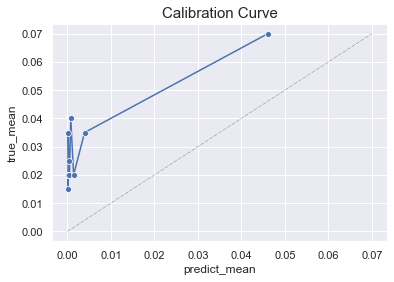

In [24]:
mlframework.plot_calibration_curve(true, pred)

It's better to examine the profitability on the test set only. Since the model learns from the train set so it's might be unfair for BAU (business as usual) to compare. But for simplicity, whole data (41,022 rows) are used.

In [18]:
def get_average_flag_bad(
    pred_score: list = None,
    approval_rate: float = 0.8,
    label: pd.Series = data['flag_bad']
):
    if pred_score is None:
        approval = label.sample(frac=approval_rate, random_state=0)
        average_flag_bad = approval.mean()
    else:
        if len(pred_score) !=  len(pred_score):
            raise ValueError('Size of prediction and true label must be equal.')
        pred_label = pd.DataFrame({
            'pred_score': pred_score,
            'label': label
        })
        approval_number = round(approval_rate * len(label))
        approval = pred_label.sort_values('pred_score').head(approval_number)
        average_flag_bad = approval['label'].mean()
    return average_flag_bad

In [19]:
def get_profit(
    pred_score: list = None,
    approval_rate: float = 0.8,
    label: pd.Series = data['flag_bad'],
    values: dict = {0: 100, 1: -650}
):
    if pred_score is None:
        approval = label.sample(frac=approval_rate, random_state=0)
        profit = approval.replace(values).sum()
    else:
        if len(pred_score) !=  len(pred_score):
            raise ValueError('Size of prediction and true label must be equal.')
        pred_label = pd.DataFrame({
            'pred_score': pred_score,
            'label': label
        })
        approval_number = round(approval_rate * len(label))
        approval = pred_label.sort_values('pred_score').head(approval_number)
        profit = approval['label'].replace(values).sum()
    return profit

In [20]:
pred_score = user_ml.predict(
    user_ml.data[user_ml.train_feat.columns]
)
pred_score

array([0.02699314, 0.09277559, 0.46961011, ..., 0.04326835, 0.01803737,
       0.11294207])

Prediction score (to be a bad user) on whole data set.

In [21]:
bau_flag_bad = get_average_flag_bad()
bau_profit = get_profit()

print('With approval rate of 80%:')
print(f'- Business as usual average flag bad: {bau_flag_bad:.1%}.')
print(f'- Business as usual profit: ${bau_profit:,}.')

With approval rate of 80%:
- Business as usual average flag bad: 13.1%.
- Business as usual profit: $68,050.


In [22]:
model_flag_bad  = get_average_flag_bad(pred_score)
model_profit  = get_profit(pred_score)

print('With approval rate of 80%:')
print(f'- Model average flag bad: {model_flag_bad:.1%}.')
print(f'- Model profit: ${model_profit:,}.')

With approval rate of 80%:
- Model average flag bad: 5.7%.
- Model profit: $1,889,050.


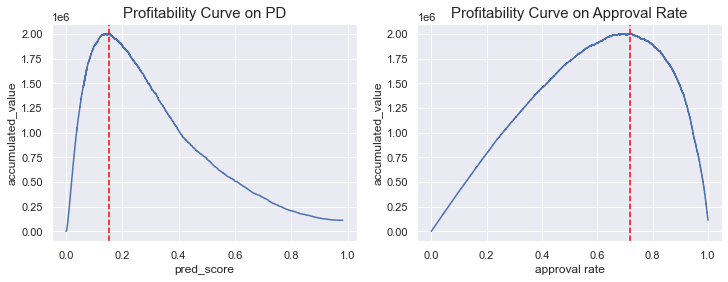

In [23]:
pred_label = pd.DataFrame({
    'pred_score': pred_score,
    'label': data['flag_bad']
})
values = {0: 100, 1: -650}
pred_label = (
    pred_label
    .sort_values('pred_score')
    .assign(value = lambda df: df['label'].replace(values))
    .assign(accumulated_value = lambda df: df['value'].cumsum())
    .reset_index(drop=True)
)

optimal_profit = pred_label['accumulated_value'].max()
optimal_index = pred_label['accumulated_value'].idxmax()
optimal_pd = pred_label['pred_score'][optimal_index]
optimal_approval_rate = (optimal_index + 1) / len(pred_label)
optimal_flag_bad = pred_label['label'][0: optimal_index + 1].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(
    x = pred_label['pred_score'],
    y = pred_label['accumulated_value']
)
plt.title('Profitability Curve on PD', size=15)
plt.axvline(optimal_pd, ls='--', color='red');
plt.subplot(1, 2, 2)
sns.lineplot(
    x = (pred_label.index + 1) / len(pred_label),
    y = pred_label['accumulated_value']
)
plt.xlabel('approval rate')
plt.title('Profitability Curve on Approval Rate', size=15)
plt.axvline(optimal_approval_rate, ls='--', color='red');

In [24]:
print(f'Optimal profit is ${optimal_profit:,}, which is achieved by PD cut-off {optimal_pd:.1%}.')
print(f'The according approval rate and average flag bad is {optimal_approval_rate:.1%} and {optimal_flag_bad:.1%}.')

Optimal profit is $2,001,200, which is achieved by PD cut-off 15.3%.
The according approval rate and average flag bad is 71.9% and 4.3%.


___

## table of contents
1. [overall](#overall)
2. [model](#model)
3. [explainable ai](#explainable_ai)
4. [test](#test)
5. [profitability](#profitability)

___